In [131]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [132]:
IMG_PATH = './img/'

In [133]:
frame = cv.imread(IMG_PATH + 'whiteCarLaneSwitch.jpg')

In [134]:
def do_canny(frame):
    
    # Converts frame to grayscale
    gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
    
    # Applies a 5x5 gaussian blur
    blur = cv.GaussianBlur(gray, (5, 5), 0)
    
    # Applies Canny edge detector
    canny = cv.Canny(blur, 50, 150)
    
    return canny

In [135]:
def do_segment(frame):
    height = frame.shape[0]
    width = frame.shape[1]
    
    # Creates a triangular polygon for the mask defined by three (x, y) coordinates
    polygons = np.array([
                            [(0, height), (width //2, height//2), (width, height)]
                        ])
    
    # Creates an image filled with zero
    mask = np.zeros_like(frame)
    
    # Allows the mask to be filled with values of 1 and the other areas to be filled with values of 0
    cv.fillPoly(mask, polygons, 255)
    
    # A bitwise and operation between the mask and frame keeps only the triangular area of the frame
    segment = cv.bitwise_and(frame, mask)
    
    return segment

In [136]:
def calculate_coordinates(frame, parameters):
    
    slope, intercept = parameters
    
    # Sets initial y-coordinate as height from top down (bottom of the frame)
    
    y1 = frame.shape[0]
    
    # Sets final y-coordinate as 50 above the bottom of the frame
    y2 = int(y1 - 200)
    
    # Sets initial x-coordinate as (y1 - b) / m since y1 = mx1 + b
    x1 = int((y1 - intercept) / slope)
    
    # Sets final x-coordinate as (y2 - b) / m since y2 = mx2 + b
    x2 = int((y2 - intercept) / slope)
    
    return np.array([x1, y1, x2, y2])

In [137]:
def calculate_lines(frame, lines):
    
    # Empty arrays to store the coordinates of the left and right lines
    left = []
    right = []
    
    # Loops through every detected line
    for line in lines:
        
        # Reshapes line from 2D array to 1D array
        x1, y1, x2, y2 = line.reshape(4)
        # Fits a linear polynomial to the x and y coordinates and returns a vector of coefficients which describe the slope and y-intercept
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        y_intercept = parameters[1]
        
        # If slope is negative, the line is to the left of the lane, and otherwise, the line is to the right of the lane
        if slope < 0:
            left.append((slope, y_intercept))
        else:
            right.append((slope, y_intercept))
    
    # Averages out all the values for left and right into a single slope and y-intercept value for each line
    left_avg = np.average(left, axis = 0)
    right_avg = np.average(right, axis = 0)
    
    # Calculates the x1, y1, x2, y2 coordinates for the left and right lines
    left_line = calculate_coordinates(frame, left_avg)
    right_line = calculate_coordinates(frame, right_avg)
    
    return np.array([left_line, right_line])

In [138]:
def visualize_lines(frame, lines):
    
    # Creates an image filled with zero intensities with the same dimensions as the frame
    lines_visualize = np.zeros_like(frame)
    
    # Checks if any lines are detected
    if lines is not None:
        for x1, y1, x2, y2 in lines:
    # Draws lines between two coordinates with green color and 5 thickness
            cv.line(lines_visualize, (x1, y1), (x2, y2), (0, 255, 0), 5)
    
    return lines_visualize

In [139]:
canny = do_canny(frame)
segment = do_segment(canny)
hough = cv.HoughLinesP(segment, 2, np.pi / 180, 100, np.array([]), minLineLength = 100, maxLineGap = 50)
lines = calculate_lines(frame, hough)
lines_visualize = visualize_lines(frame, lines)
output = cv.addWeighted(frame, 0.9, lines_visualize, 1, 1)

In [140]:
#cv.imshow('image', output)
#cv.waitKey(0)
#cv.destroyAllWindows()

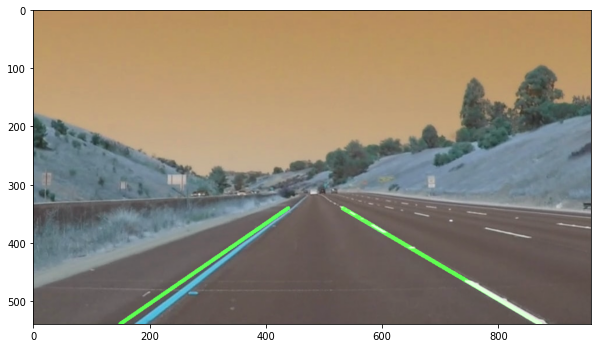

In [141]:
figure = plt.figure(figsize=(10,10))
plt.imshow(output)